In [ ]:
import pandas as pd
import numpy as np
import talib
import pandas_profiling as pdp
import sweetviz as sv

import os
import sys
from pygam import s, LinearGAM
import category_encoders as ce
from typing import List, Dict

import matplotlib.pyplot as plt
import seaborn as sns

import ptitprince
from matplotlib_venn import venn2
plt.rcParams["font.family"] = "Hiragino Maru Gothic Pro"

from common_module.utils.plot import (
    plot_venn,
    plot_histogram,
    plot_raincloud,
    plot_heatmap,
    plot_histgram_for_valid,
    plot_lineargam,
    plot_feature_importance_for_valid
)
from common_module.utils.summarize import (
    get_pandas_profiling,
    get_sweetviz_report
)
from common_module.utils.preprocessor import (
    OrdinalEncodingBlock,
    CountEncodingBlock,
    GroupingBlock
)
from common_module.utils.format_df import format_df
from common_module.utils.utils import (
    reduce_mem_usage,
    save_pickle,
    load_pickle
)

from probspace_usstock.modules.config_manager import ConfigManager
from probspace_usstock.modules.features import (
    create_company_features,
    calc_Symbol_lag_features,
    calc_Symbol_lag_log_features,
    # calc_List_lag_features,
    calc_Symbol_lag_log1pRate_features,
    calc_category_lag_log1pRate_features,
    create_percentile_flg_columns,
    create_ymd_features
)
from probspace_usstock.modules.preprocessor import (
    melt_dataframe,
    create_base_dataframe,
    calc_seasonal_decompose
)
from probspace_usstock.modules.parameter_tuner import OptunaParameterTuning
from probspace_usstock.modules.train_module import (
    TrainLGBModule,
    TrainCABModule,
    TrainXGBModule
)
from probspace_usstock.modules.predict import (
    make_pred_df,
    PredictModule
)

sys.path.append("../")
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 100)

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# read
df_train_origin = pd.read_csv("../input/train_data.csv", encoding="utf-8-sig")
df_company_list_origin = pd.read_csv("../input/company_list.csv", encoding="utf-8-sig")
df_sub_template = pd.read_csv("../input/submission_template.csv", encoding="utf-8-sig")

# shape
display(df_train_origin.shape)
display(df_company_list_origin.shape)
display(df_sub_template.shape)

(420, 3279)

(7007, 6)

(3278, 2)

In [3]:
print("■train_data")
display(df_train_origin.shape)
display(df_train_origin.head(4))

print("■company_list")
display(df_company_list_origin.shape)
display(df_company_list_origin.head(1))

print("■submission_template")
display(df_sub_template.shape)
display(df_sub_template.head(1))

■train_data


(420, 3279)

,Date,VGSH,JEF,IVZ,KTCC,FBZ,PLOW,JBK,IAC,IVR,VSH,VCV,OKE,ROK,FTAG,BRKR,GSK,JPS,SRPT,VMI,IMKTA,BDR,JAKK,MVC,AMSF,APTO,CNX,XOMA,LBY,BIOL,PAAS,KOF,LAC,EML,IVC,TILE,IEF,CSV,QADA,TBNK,HOG,WIW,SVBI,PKOH,CREG,LOGM,ERII,PEBO,PEER,ORA,RIO,BPOPM,PDLI,RYN,UNAM,PFD,CALX,SNSS,TCF,MTRX,AVGO,MSM,REV,HSY,PEP,REED,HPQ,BKTI,MPB,AAON,PSO,CIG,NAC,OPNT,RE,SES,RTN,WST,HIHO,FLC,EFT,DCI,IIF,BANC,CRS,GAIN,UHT,TMO,MFNC,TEX,LTBR,QGEN,EVV,BBY,MRKR,CSQ,KBAL,QRHC,ANIP,FMBH,...,CONN,EGO,CY,ICLN,NNVC,AIZ,XAN,ALIM,PFL,WIA,TRST,EXD,HNW,SBLK,AUBN,GSIT,ISSC,ESGR,CAMT,CKH,CLS,ZTR,SIRI,PFM,ANTE,PZC,DSLV,WDC,PRPH,RS,BOTJ,CE,HAIN,QCLN,ATR,WSM,LNG,VTWO,FRC,FUL,ICFI,CIZN,UFI,MXIM,MRLN,GTT,CR,SXT,NBTB,ADI,EVK,WSBC,ACER,CHN,CORT,FLIC,ADTN,PFLT,AVID,TSEM,KRO,MORN,BHV,MMU,SGRP,PBA,GF,OSPN,J,AMKR,CPHI,TRT,OPRX,DXYN,GFED,FRAF,HWCC,WYND,CHMG,EVC,NNA,IOR,ATLC,STWD,TTM,NOC,EQS,MKC,MXL,NEV,ASFI,JTA,MNR,TFSL,GTN,TYG,VIRC,BIS,WOOD,MASI
0,2011/11/13,55.942184,17.649006,13.770864,4.77,13.818835,10.198389,12.440549,38.484608,4.836254,8.575465,7.877108,23.100210,59.334507,84.253273,11.731660,28.273636,4.168243,4.86,75.028809,12.110400,1.13,18.456266,7.713052,15.194721,2.88,29.963728,30.400000,10.973586,14.384466,20.405405,73.412354,1.75,16.415005,19.071070,10.358725,88.829475,5.339281,10.804994,15.035470,29.228592,9.278417,2.594832,17.814543,14.5,38.607750,2.50,9.508274,22.400000,17.544151,34.077663,9.051845,4.036423,21.052782,10.179731,7.213885,8.41,7.50,14.216700,9.68,24.646343,50.906437,14.46,46.303482,49.788853,1.39,8.927394,0.877275,6.139855,8.682248,12.204165,3.919564,8.690806,0.42,73.116982,98.559998,35.922192,17.122187,1.637933,9.453785,8.308208,28.895016,9.979239,8.690458,45.424389,3.396492,23.906984,44.114647,3.987525,13.897991,187.800003,13.728254,7.737930,21.358797,288.0,4.088526,3.683195,18.000000,84.599998,14.962660,...,9.95,83.039902,13.923010,7.072347,55.299999,31.703871,11.661029,1.29,4.546225,9.558780,3.620234,7.187960,8.973720,84.834564,14.881336,4.86,3.010909,96.360001,1.812006,58.838348,8.25,4.215335,1.700923,11.964488,14.300000,5.702804,43.799999,20.713301,0.762946,36.546154,4.475960,35.595501,17.670000,9.581954,42.146973,29.780903,11.70,51.195068,22.606068,20.090033,24.530502,11.557922,7.89,19.594046,8.667803,1.36,38.136402,30.210152,15.731730,28.358801,1.37,15.125630,373.333344,10.369422,3.39,9.227671,27.211815,5.037442,7.10,10.65,12.701912,53.690952,13.001904,8.411827,1.22,16.457903,6.239215,8.04,39.470684,4.63,0.88,2.40,3.06,2.93,4.992733,10.988591,9.748321,10.293147,17.453051,1.078169,33.496590,1.92,3.16,6.810544,15.831424,47.542465,2.21,40.948685,4.96,8.450615,3.721562,4.747546,5.567790,7.262252,1.80,20.079035,1.504111,826.767029,30.918266,18.430309
1,2011/11/20,55.978844,16.270664,12.719761,4.94,12.744166,10.035272,12.065370,36.252533,4.658076,7.657301,7.939425,22.540537,55.720310,78.528595,11.262002,27.104542,4.072667,4.08,69.938858,11.282884,1.14,17.461733,6.991731,14.490328,2.52,27.630514,30.799999,10.061356,12.466537,20.022963,68.245247,1.65,16.306412,18.346851,8.876307,89.084717,5.274280,9.564995,14.278780,27.989960,9.314977,2.662356,15.294662,12.5,34.829571,2.27,7.991528,22.400000,15.904687,30.586075,9.023554,4.063376,19.843987,10.206950,7.154890,7.18,6.90,12.750013,8.53,23.474276,48.047035,13.74,45.746265,48.697853,1.40,8.098125,0.919861,6.164315,7.810735,11.651024,3.674882,8.618720,0.40,69.981857,89.599998,35.203728,16.185606,1.494254,9.253301,8.163390,27.018999,9.378841,7.772503,41.059013,3.186542,22.347122,42.692211,4.068903,11.817956,160.800003,13.438292,7.711720,20.230078,264.0,3.903125,3.333358,19.600000,79.919998,15.667272,...,10.10,79.030418,12.645804,6.734447,49.700001,30.477777,11.191008,1.19,4.488735,9.543862,3.398002,7.272264,8.764602,84.780708,14.881336,4.69,2.892424,91.690002,1.634359,56.146488,7.54,4.132953,1.672256,11.491554,15.050000,5.714909,47.240002,19.886042,0.835607,35.020405,3.670286,35.281651,17.620001,8.790443,40.813152,28.370873,10.21,47.593803,21.723381,18.736162,23.587021,11.517131,7.39,18.258261,7.567554,1.30,36.288921,

■company_list


(7007, 6)

,Symbol,Name,IPOyear,Sector,Industry,List
0,XXII,"22nd Century Group, Inc",NaN,Consumer Non-Durables,Farming/Seeds/Milling,AMEX


■submission_template


(3278, 2)

,id,y
0,VGSH,NaN


## baseとなるdataframeを作成する

In [4]:
config_path = "../config/setting.yaml"
config_manager = ConfigManager(config_path=config_path)

In [5]:
# company関連の特徴量を先に作ってListをマージしたい
df_company_features = create_company_features(
    input=df_company_list_origin,
    duplicate_companies=config_manager.duplicate_companies
)
display(df_company_features.head(2))
display(df_company_features.shape)

,Symbol,IPOyear,List,Sector,Industry
0,XXII,NaN,AMEX,Consumer Non-Durables,Farming/Seeds/Milling
1,FAX,1986.0,AMEX,unknown,unknown


(6991, 5)

In [6]:
df_base = melt_dataframe(input=df_train_origin)
df_base = create_base_dataframe(input=df_base, df_company=df_company_features)

# company_listに登録されていない会社があるので情報をunknownで埋める
for cat in ["List", "Sector", "Industry"]:
    df_base[cat] = df_base[cat].fillna("unknown")

display(df_base.tail(2))
display(df_base.info())

,Date,Symbol,stock_price,List,Sector,Industry
1376758,2019/11/24,WOOD,NaN,NASDAQ,unknown,unknown
1376759,2019/11/24,MASI,NaN,NASDAQ,Health Care,Biotechnology: Electromedical & Electrotherape...


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1376760 entries, 0 to 1376759
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Date         1376760 non-null  object 
 1   Symbol       1376760 non-null  object 
 2   stock_price  1373482 non-null  float64
 3   List         1376760 non-null  object 
 4   Sector       1376760 non-null  object 
 5   Industry     1376760 non-null  object 
dtypes: float64(1), object(5)
memory usage: 73.5+ MB


None

## 特徴量作成

In [7]:
%%time

df_ymd = create_ymd_features(input=df_base)
df_Symbol_lag = calc_Symbol_lag_log1pRate_features(input=df_base)

target_cols = ["stock_price_log1pRate_1s", "stock_price_log1pRate_2s"]
methods = ["mean", "median", "std"]
df_List_lag = calc_category_lag_log1pRate_features(input=df_Symbol_lag, category="List", target_cols=target_cols, methods=methods)
df_Sector_lag = calc_category_lag_log1pRate_features(input=df_Symbol_lag, category="Sector", target_cols=target_cols, methods=methods)
df_Industry_lag = calc_category_lag_log1pRate_features(input=df_Symbol_lag, category="Industry", target_cols=target_cols, methods=methods)
# df_flg = create_percentile_flg_columns(input=df_Symbol_lag)

display(df_ymd.head(2))
display(df_Symbol_lag.head(2))
display(df_List_lag.head(2))
display(df_Sector_lag.head(2))
display(df_Industry_lag.head(2))
# display(df_Sector_lag.head(2))
# display(df_flg.head(2))

end making Symbol lag ...
end making List lag ...
end making Sector lag ...
end making Industry lag ...


,Date,year,month,day,week_of_month,week_of_year
0,2011/11/13,2011,11,13,2,45
1,2011/11/20,2011,11,20,3,46


,Date,Symbol,List,Sector,Industry,stock_price_1s,stock_price_log1pRate,stock_price_log1pRate_1s,stock_price_log1pRate_2s,stock_price_log1pRate_3s,stock_price_log1pRate_4s,stock_price_log1pRate_1s_4r_mean,stock_price_log1pRate_1s_4r_median,stock_price_log1pRate_1s_4r_max,stock_price_log1pRate_1s_4r_min,stock_price_log1pRate_1s_4r_std,stock_price_log1pRate_1s_8r_mean,stock_price_log1pRate_1s_8r_median,stock_price_log1pRate_1s_8r_max,stock_price_log1pRate_1s_8r_min,stock_price_log1pRate_1s_8r_std,stock_price_log1pRate_1s_12r_mean,stock_price_log1pRate_1s_12r_median,stock_price_log1pRate_1s_12r_max,stock_price_log1pRate_1s_12r_min,stock_price_log1pRate_1s_12r_std,stock_price_log1pRate_1s_24r_mean,stock_price_log1pRate_1s_24r_median,stock_price_log1pRate_1s_24r_max,stock_price_log1pRate_1s_24r_min,stock_price_log1pRate_1s_24r_std,stock_price_log1pRate_1s_36r_mean,stock_price_log1pRate_1s_36r_median,stock_price_log1pRate_1s_36r_max,stock_price_log1pRate_1s_36r_min,stock_price_log1pRate_1s_36r_std
0,2011/11/13,VGSH,NASDAQ,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/11/20,VGSH,NASDAQ,unknown,unknown,55.942184,0.693475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Date,List,stock_price_log1pRate_1s_List_mean,stock_price_log1pRate_1s_List_median,stock_price_log1pRate_1s_List_std,stock_price_log1pRate_2s_List_mean,stock_price_log1pRate_2s_List_median,stock_price_log1pRate_2s_List_std
0,2011/11/13,AMEX,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/11/13,NASDAQ,NaN,NaN,NaN,NaN,NaN,NaN


,Date,Sector,stock_price_log1pRate_1s_Sector_mean,stock_price_log1pRate_1s_Sector_median,stock_price_log1pRate_1s_Sector_std,stock_price_log1pRate_2s_Sector_mean,stock_price_log1pRate_2s_Sector_median,stock_price_log1pRate_2s_Sector_std
0,2011/11/13,Basic Industries,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/11/13,Capital Goods,NaN,NaN,NaN,NaN,NaN,NaN


,Date,Industry,stock_price_log1pRate_1s_Industry_mean,stock_price_log1pRate_1s_Industry_median,stock_price_log1pRate_1s_Industry_std,stock_price_log1pRate_2s_Industry_mean,stock_price_log1pRate_2s_Industry_median,stock_price_log1pRate_2s_Industry_std
0,2011/11/13,Accident &Health Insurance,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/11/13,Advertising,NaN,NaN,NaN,NaN,NaN,NaN


CPU times: user 42.7 s, sys: 1.27 s, total: 44 s
Wall time: 45.9 s


In [8]:
%%time

df_merge = pd.merge(df_base, df_company_features.drop(["List", "Sector", "Industry"], axis=1), how="left", on="Symbol")
df_merge = pd.merge(df_merge, df_ymd, how="left", on="Date")
df_merge = pd.merge(df_merge, df_Symbol_lag.drop(["List", "Sector", "Industry"], axis=1), how="left", on=["Date", "Symbol"])
df_merge = pd.merge(df_merge, df_List_lag, how="left", on=["Date", "List"])
df_merge = pd.merge(df_merge, df_Sector_lag, how="left", on=["Date", "Sector"])
df_merge = pd.merge(df_merge, df_Industry_lag, how="left", on=["Date", "Industry"])

# df_merge = pd.merge(df_merge, df_flg, how="left", on=["Date", "Symbol"])

CPU times: user 3.46 s, sys: 2.02 s, total: 5.48 s
Wall time: 6.01 s


In [9]:
df_merge.head()

,Date,Symbol,stock_price,List,Sector,Industry,IPOyear,year,month,day,week_of_month,week_of_year,stock_price_1s,stock_price_log1pRate,stock_price_log1pRate_1s,stock_price_log1pRate_2s,stock_price_log1pRate_3s,stock_price_log1pRate_4s,stock_price_log1pRate_1s_4r_mean,stock_price_log1pRate_1s_4r_median,stock_price_log1pRate_1s_4r_max,stock_price_log1pRate_1s_4r_min,stock_price_log1pRate_1s_4r_std,stock_price_log1pRate_1s_8r_mean,stock_price_log1pRate_1s_8r_median,stock_price_log1pRate_1s_8r_max,stock_price_log1pRate_1s_8r_min,stock_price_log1pRate_1s_8r_std,stock_price_log1pRate_1s_12r_mean,stock_price_log1pRate_1s_12r_median,stock_price_log1pRate_1s_12r_max,stock_price_log1pRate_1s_12r_min,stock_price_log1pRate_1s_12r_std,stock_price_log1pRate_1s_24r_mean,stock_price_log1pRate_1s_24r_median,stock_price_log1pRate_1s_24r_max,stock_price_log1pRate_1s_24r_min,stock_price_log1pRate_1s_24r_std,stock_price_log1pRate_1s_36r_mean,stock_price_log1pRate_1s_36r_median,stock_price_log1pRate_1s_36r_max,stock_price_log1pRate_1s_36r_min,stock_price_log1pRate_1s_36r_std,stock_price_log1pRate_1s_List_mean,stock_price_log1pRate_1s_List_median,stock_price_log1pRate_1s_List_std,stock_price_log1pRate_2s_List_mean,stock_price_log1pRate_2s_List_median,stock_price_log1pRate_2s_List_std,stock_price_log1pRate_1s_Sector_mean,stock_price_log1pRate_1s_Sector_median,stock_price_log1pRate_1s_Sector_std,stock_price_log1pRate_2s_Sector_mean,stock_price_log1pRate_2s_Sector_median,stock_price_log1pRate_2s_Sector_std,stock_price_log1pRate_1s_Industry_mean,stock_price_log1pRate_1s_Industry_median,stock_price_log1pRate_1s_Industry_std,stock_price_log1pRate_2s_Industry_mean,stock_price_log1pRate_2s_Industry_median,stock_price_log1pRate_2s_Industry_std
0,2011/11/13,VGSH,55.942184,NASDAQ,unknown,unknown,NaN,2011,11,13,2,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/11/20,VGSH,55.978844,NASDAQ,unknown,unknown,NaN,2011,11,20,3,46,55.942184,0.693475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011/11/27,VGSH,56.021038,NASDAQ,unknown,unknown,NaN,2011,11,27,4,47,55.978844,0.693524,0.693475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666961,0.667997,0.030833,NaN,NaN,NaN,0.680703,0.683254,0.016954,NaN,NaN,NaN,0.680703,0.683254,0.016954,NaN,NaN,NaN
3,2011/12/4,VGSH,56.002697,NASDAQ,unknown,unknown,NaN,2011,12,4,1,48,56.021038,0.692983,0.693524,0.693475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.724171,0.726499,0.052212,0.666961,0.667997,0.030833,0.712097,0.709316,0.019961,0.680703,0.683254,0.016954,0.712097,0.709316,0.019961,0.680703,0.683254,0.016954
4,2011/12/11,VGSH,56.030224,NASDAQ,unknown,unknown,NaN,2011,12,11,2,49,56.002697,0.693393,0.692983,0.693524,0.693475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.696409,0.694824,0.037425,0.724171,0.726499,0.052212,0.695239,0.695314,0.007917,0.712097,0.709316,0.019961,0.695239,0.695314,0.007917,0.712097,0.709316,0.019961


In [10]:
# NaNがある期間は学習に使用しない
print(df_merge.shape)
df_merge = df_merge[df_merge["stock_price_log1pRate_1s_12r_mean"].notnull()]
# df_merge = df_merge[df_merge["stock_price_log1pRate_1s_List_mean"].notnull()]
# df_merge = df_merge[df_merge["stock_price_1s_12r_mean"].notnull()]
print(df_merge.shape)
df_merge = reduce_mem_usage(df_merge)
df_merge.info()

(1376760, 61)
(1334146, 61)
Memory usage of dataframe is 631.08 MB
Memory usage after optimization is: 156.67 MB
Decreased by 75.2%
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1334146 entries, 13 to 1376759
Data columns (total 61 columns):
 #   Column                                    Non-Null Count    Dtype   
---  ------                                    --------------    -----   
 0   Date                                      1334146 non-null  category
 1   Symbol                                    1334146 non-null  category
 2   stock_price                               1330868 non-null  float16 
 3   List                                      1334146 non-null  category
 4   Sector                                    1334146 non-null  category
 5   Industry                                  1334146 non-null  category
 6   IPOyear                                   440781 non-null   float16 
 7   year                                      1334146 non-null  int16   
 8   month    

In [12]:
save_pickle(object=df_merge, file_name="df_merge.pickle", file_path="../output/")

done


In [5]:
df_merge = load_pickle(file_name="df_merge.pickle", file_path="../output/")

## 学習

In [6]:
df_merge = format_df(df_merge, config_manager.feature_columns)

In [7]:
def split_dataframe(input: pd.DataFrame, config: Dict) -> pd.DataFrame:
    df_train = input[
        (pd.to_datetime(input["Date"]) >= pd.to_datetime(config.train_period[0])) &
        (pd.to_datetime(input["Date"]) <= pd.to_datetime(config.train_period[1]))
    ].copy()
    df_val = input[
        (pd.to_datetime(input["Date"]) >= pd.to_datetime(config.valid_period[0])) &
        (pd.to_datetime(input["Date"]) <= pd.to_datetime(config.valid_period[1]))
    ].copy()
    df_test = input[
        (pd.to_datetime(input["Date"]) >= pd.to_datetime(config.test_period[0])) &
        (pd.to_datetime(input["Date"]) <= pd.to_datetime(config.test_period[1]))
    ].copy()
    return df_train, df_val, df_test

df_train, df_val, df_test = split_dataframe(input=df_merge, config=config_manager)

In [8]:
df_train.head()

,Date,Symbol,stock_price,List,Sector,Industry,IPOyear,year,month,day,week_of_month,week_of_year,stock_price_1s,stock_price_log1pRate,stock_price_log1pRate_1s,stock_price_log1pRate_2s,stock_price_log1pRate_3s,stock_price_log1pRate_4s,stock_price_log1pRate_1s_4r_mean,stock_price_log1pRate_1s_4r_median,stock_price_log1pRate_1s_4r_max,stock_price_log1pRate_1s_4r_min,stock_price_log1pRate_1s_4r_std,stock_price_log1pRate_1s_8r_mean,stock_price_log1pRate_1s_8r_median,stock_price_log1pRate_1s_8r_max,stock_price_log1pRate_1s_8r_min,stock_price_log1pRate_1s_8r_std,stock_price_log1pRate_1s_12r_mean,stock_price_log1pRate_1s_12r_median,stock_price_log1pRate_1s_12r_max,stock_price_log1pRate_1s_12r_min,stock_price_log1pRate_1s_12r_std,stock_price_log1pRate_1s_24r_mean,stock_price_log1pRate_1s_24r_median,stock_price_log1pRate_1s_24r_max,stock_price_log1pRate_1s_24r_min,stock_price_log1pRate_1s_24r_std,stock_price_log1pRate_1s_36r_mean,stock_price_log1pRate_1s_36r_median,stock_price_log1pRate_1s_36r_max,stock_price_log1pRate_1s_36r_min,stock_price_log1pRate_1s_36r_std,stock_price_log1pRate_1s_List_mean,stock_price_log1pRate_1s_List_median,stock_price_log1pRate_1s_List_std,stock_price_log1pRate_2s_List_mean,stock_price_log1pRate_2s_List_median,stock_price_log1pRate_2s_List_std,stock_price_log1pRate_1s_Sector_mean,stock_price_log1pRate_1s_Sector_median,stock_price_log1pRate_1s_Sector_std,stock_price_log1pRate_2s_Sector_mean,stock_price_log1pRate_2s_Sector_median,stock_price_log1pRate_2s_Sector_std,stock_price_log1pRate_1s_Industry_mean,stock_price_log1pRate_1s_Industry_median,stock_price_log1pRate_1s_Industry_std,stock_price_log1pRate_2s_Industry_mean,stock_price_log1pRate_2s_Industry_median,stock_price_log1pRate_2s_Industry_std
13,2012/2/12,VGSH,56.00000,NASDAQ,unknown,unknown,NaN,2012,2,12,2,6,56.03125,0.692871,0.693359,0.692383,0.693848,0.693359,0.693359,0.693359,0.693848,0.692383,0.000563,0.693359,0.693359,0.693848,0.692383,0.000493,0.693359,0.693359,0.693848,0.692383,0.000423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.692383,0.687500,0.069031,0.710449,0.707520,0.039246,0.692383,0.692871,0.009399,0.703613,0.702637,0.018112,0.692383,0.692871,0.009399,0.703613,0.702637,0.018112
14,2012/2/19,VGSH,55.96875,NASDAQ,unknown,unknown,NaN,2012,2,19,3,7,56.00000,0.692871,0.692871,0.693359,0.692383,0.693848,0.693359,0.692871,0.693848,0.692383,0.000602,0.693359,0.693359,0.693848,0.692383,0.000491,0.693359,0.693359,0.693848,0.692383,0.000430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.702148,0.700684,0.029510,0.692383,0.687500,0.069031,0.695312,0.695801,0.010849,0.692383,0.692871,0.009399,0.695312,0.695801,0.010849,0.692383,0.692871,0.009399
15,2012/2/26,VGSH,56.00000,NASDAQ,unknown,unknown,NaN,2012,2,26,4,8,55.96875,0.693848,0.692871,0.692871,0.693359,0.692383,0.692871,0.692871,0.693359,0.692383,0.000271,0.692871,0.692871,0.693848,0.692383,0.000468,0.692871,0.692871,0.693848,0.692383,0.000430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.693359,0.692383,0.032898,0.702148,0.700684,0.029510,0.696777,0.696289,0.007633,0.695312,0.695801,0.010849,0.696777,0.696289,0.007633,0.695312,0.695801,0.010849
16,2012/3/4,VGSH,56.00000,NASDAQ,unknown,unknown,NaN,2012,3,4,1,9,56.00000,0.692871,0.693848,0.692871,0.692871,0.693359,0.692871,0.692871,0.693848,0.692871,0.000416,0.693359,0.693359,0.693848,0.692383,0.000466,0.693359,0.693359,0.693848,0.692383,0.000455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.684570,0.686523,0.035736,0.693359,0.692383,0.032898,0.693848,0.694336,0.010384,0.696777,0.696289,0.007633,0.693848,0.694336,0.010384,0.696777,0.696289,0.007633
17,2012/3/11,VGSH,55.93750,NASDAQ,unknown,unknown,NaN,2012,3,11,2,10,56.00000,0.692383,0.692871,0.693848,0.692871,0.692871,0.692871,0.692871,0.693848,0.692871,0.000408,0.693359,0.692871,0.693848,0.692383,0.000464,0.693359,0.692871,0.693848,0.692383,0.000449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.699707,0.697754,0.028046,0.684570,0.686523,0.035736,0.692871,0.692871,0.006943,0.693848,0.694336,0.010384,0.692871,0.692871,0.

### LightGBM

#### パラメータ調整

In [15]:
%%time

NEED_TUNING = False
# optuna
if NEED_TUNING:
    ins_optuna = OptunaParameterTuning(config=config_manager, target=config_manager.pred_cols)
    best_params = ins_optuna.tune_model_parameter(df_train=df_train, df_val=df_val, have_weight=True)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs


#### 学習

In [11]:
# train
ins_lgb = TrainLGBModule(config=config_manager, target=config_manager.pred_cols)
trained_model_lgb, df_imp_lgb, evals_result_lgb = ins_lgb.train_model(
    df_train=df_train, df_val=df_val, have_weight=False)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[544]	valid_0's rmse: 0.0319187


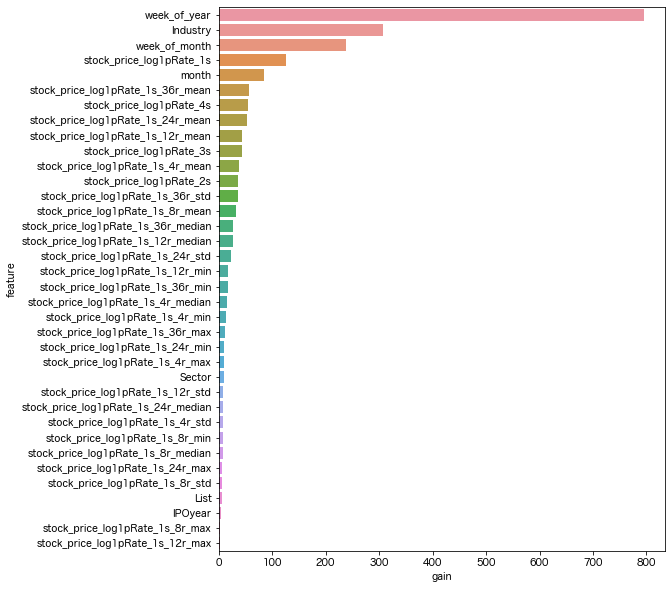

In [12]:
df_imp_ = df_imp_lgb.sort_values("gain", ascending=False)
plt.figure(figsize=(8, 10))
sns.barplot(x=df_imp_["gain"], y=df_imp_["feature"]);

#### 予測

In [13]:
ins_pred_lgb = PredictModule(config=config_manager, model_type="lightgbm", is_test=True)
df_test_pred_lgb = ins_pred_lgb.predict(model=trained_model_lgb, test_df=df_test)

# df_test_pred_lgb = make_pred_df(
#     model=trained_model_lgb,
#     target=config_manager.pred_cols,
#     df_test=df_test[config_manager.feature_columns.keys()],
#     config=config_manager,
#     is_test=True,
#     cv_num=1
# )

df_test_pred_lgb = pd.merge(
    df_test_pred_lgb,
    df_test[["Date", "Symbol", "stock_price_log1pRate", "stock_price_1s"]],
    # df_test[["Date", "Symbol", "stock_price", "stock_price_1s_4r_mean"]],
    how="left",
    on=["Date", "Symbol"]
)

pred stock_price_log1pRate ...


In [14]:
df_test_pred_lgb.head()

,Date,Symbol,cv_num,pred_stock_price_log1pRate,stock_price_log1pRate,stock_price_1s
0,2019/11/17,VGSH,1,0.694906,0.692871,60.406250
1,2019/11/17,JEF,1,0.698375,0.736328,18.968750
2,2019/11/17,IVZ,1,0.699299,0.689941,17.156250
3,2019/11/17,KTCC,1,0.698542,0.655762,5.960938
4,2019/11/17,FBZ,1,0.695025,0.694336,14.726562


#### 提出

In [15]:
submission_Date = "2019/11/24"
# stock_price_log1p
df_submission = df_test_pred_lgb[df_test_pred_lgb["Date"] == submission_Date][["Symbol", "pred_stock_price_log1pRate", "stock_price_1s"]].copy()
df_submission["undo_pred_stock_price"] = np.expm1(df_submission["pred_stock_price_log1pRate"]) * df_submission["stock_price_1s"]
df_submission = df_submission.rename(columns={"Symbol": "id", "undo_pred_stock_price": "y"})
df_submission[["id", "y"]].to_csv("../output/submission_14_lgb.csv", index=False, encoding="utf-8-sig")

## xgboost

In [9]:
ins_train_xgb = TrainXGBModule(config=config_manager, target=config_manager.pred_cols)
model_xgb, df_imp_xgb, evals_result = ins_train_xgb.train_model(df_train=df_train, df_val=df_val, have_weight=False)

[0]	train-rmse:0.13872	valid-rmse:0.14123
[118]	train-rmse:0.02646	valid-rmse:0.03231


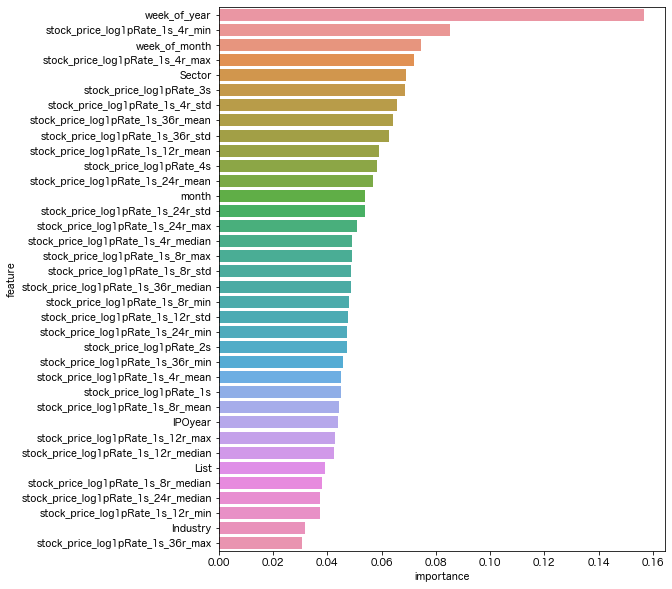

In [10]:
df_imp_ = df_imp_xgb.sort_values("importance", ascending=False)
plt.figure(figsize=(8, 10))
sns.barplot(x=df_imp_["importance"], y=df_imp_["feature"]);

### 予測

In [11]:
ins_pred_xgb = PredictModule(config=config_manager, model_type="xgboost", is_test=True)
df_test_pred_xgb = ins_pred_xgb.predict(model=model_xgb, test_df=df_test)

# df_test_pred_xgb = make_pred_df(
#     model=model_xgb,
#     target=config_manager.pred_cols,
#     df_test=df_test[config_manager.feature_columns.keys()],
#     config=config_manager,
#     is_test=True,
#     cv_num=1
# )

df_test_pred_xgb = pd.merge(
    df_test_pred_xgb,
    df_test[["Date", "Symbol", "stock_price_log1pRate", "stock_price_1s"]],
    # df_test[["Date", "Symbol", "stock_price", "stock_price_1s_4r_mean"]],
    how="left",
    on=["Date", "Symbol"]
)

pred stock_price_log1pRate ...


#### 提出

In [12]:
submission_Date = "2019/11/24"
# stock_price_log1p
df_submission = df_test_pred_xgb[df_test_pred_xgb["Date"] == submission_Date][["Symbol", "pred_stock_price_log1pRate", "stock_price_1s"]].copy()
df_submission["undo_pred_stock_price"] = np.expm1(df_submission["pred_stock_price_log1pRate"]) * df_submission["stock_price_1s"]
df_submission = df_submission.rename(columns={"Symbol": "id", "undo_pred_stock_price": "y"})
df_submission[["id", "y"]].to_csv("../output/submission_14_xgb.csv", index=False, encoding="utf-8-sig")

### Catboost

In [13]:
ins_train_cat = TrainCABModule(config=config_manager, target=config_manager.pred_cols)
model_cat, df_imp_cat = ins_train_cat.train_model(df_train=df_train, df_val=df_val, have_weight=False)

0:	learn: 0.0285935	test: 0.0320712	best: 0.0320712 (0)	total: 527ms	remaining: 43m 54s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.03194116278
bestIteration = 898

Shrink model to first 899 iterations.


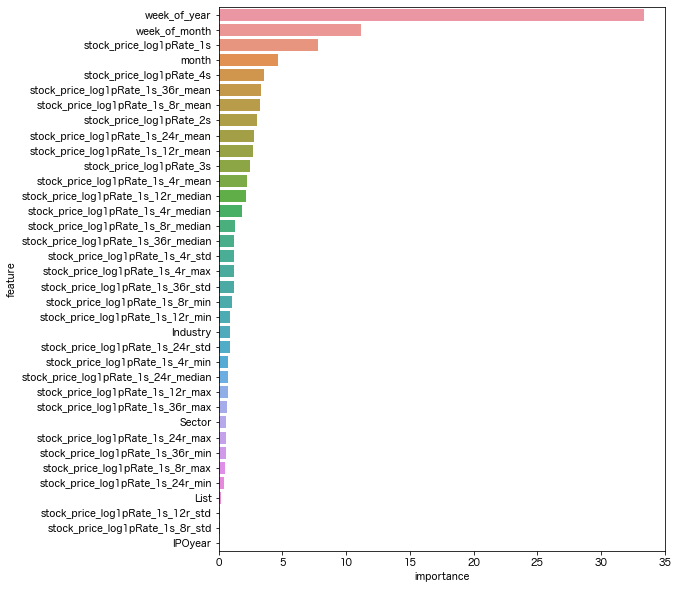

In [14]:
df_imp_ = df_imp_cat.sort_values("importance", ascending=False)
plt.figure(figsize=(8, 10))
sns.barplot(x=df_imp_["importance"], y=df_imp_["feature"]);

In [17]:
ins_pred_cat = PredictModule(config=config_manager, model_type="catboost", is_test=True)
df_test_pred_cat = ins_pred_cat.predict(model=model_cat, test_df=df_test)

# df_test_pred = make_pred_df(
#     model=model_cat,
#     target=config_manager.pred_cols,
#     df_test=df_test[config_manager.feature_columns.keys()],
#     config=config_manager,
#     is_test=True,
#     cv_num=1
# )
df_test_pred_cat = pd.merge(
    df_test_pred_cat,
    df_test[["Date", "Symbol", "stock_price_log1pRate", "stock_price_1s"]],
    # df_test[["Date", "Symbol", "stock_price", "stock_price_1s_4r_mean"]],
    how="left",
    on=["Date", "Symbol"]
)

display(df_test_pred_cat.head())
display(df_test_pred_cat.shape)

pred stock_price_log1pRate ...


,Date,Symbol,cv_num,pred_stock_price_log1pRate,stock_price_log1pRate,stock_price_1s
0,2019/11/17,VGSH,1,0.695956,0.692871,60.406250
1,2019/11/17,JEF,1,0.697744,0.736328,18.968750
2,2019/11/17,IVZ,1,0.697766,0.689941,17.156250
3,2019/11/17,KTCC,1,0.699547,0.655762,5.960938
4,2019/11/17,FBZ,1,0.696500,0.694336,14.726562


(6556, 6)

In [18]:
submission_Date = "2019/11/24"
# stock_price_log1p
df_submission = df_test_pred_cat[df_test_pred_cat["Date"] == submission_Date][["Symbol", "pred_stock_price_log1pRate", "stock_price_1s"]].copy()
df_submission["undo_pred_stock_price"] = np.expm1(df_submission["pred_stock_price_log1pRate"]) * df_submission["stock_price_1s"]
df_submission = df_submission.rename(columns={"Symbol": "id", "undo_pred_stock_price": "y"})
df_submission[["id", "y"]].to_csv("../output/submission_14_cat.csv", index=False, encoding="utf-8-sig")

## アンサンブル

In [19]:
df_sub_lgb = pd.read_csv("../output/submission_14_lgb.csv", encoding="utf-8-sig")
df_sub_xgb = pd.read_csv("../output/submission_14_xgb.csv", encoding="utf-8-sig")
df_sub_cat = pd.read_csv("../output/submission_14_cat.csv", encoding="utf-8-sig")

# rename
df_sub_lgb = df_sub_lgb.rename(columns={"y": "y_lgb"})
df_sub_xgb = df_sub_xgb.rename(columns={"y": "y_xgb"})
df_sub_cat = df_sub_cat.rename(columns={"y": "y_cat"})

# merge & mean
df_sub_all = pd.merge(df_sub_lgb, df_sub_xgb, how="left", on="id")
df_sub_all = pd.merge(df_sub_all, df_sub_cat, how="left", on="id")
df_sub_all["y"] = (df_sub_all["y_lgb"] + df_sub_all["y_xgb"] + df_sub_all["y_cat"]) / 3
df_sub_all[["id", "y"]].to_csv("../output/submission_14_all.csv", index=False, encoding="utf-8-sig")

## visualize

(array([2.799e+03, 3.940e+02, 4.100e+01, 1.800e+01, 9.000e+00, 5.000e+00,
        4.000e+00, 5.000e+00, 2.000e+00, 1.000e+00]),
 array([0.69355786, 0.69400669, 0.69445552, 0.69490434, 0.69535317,
        0.695802  , 0.69625083, 0.69669966, 0.69714848, 0.69759731,
        0.69804614]),
 <BarContainer object of 10 artists>)

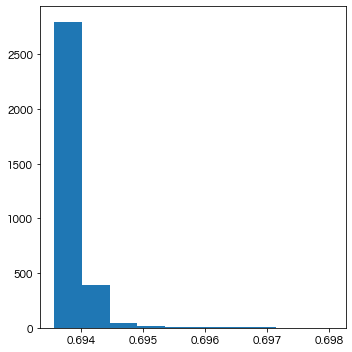

In [79]:
assessment_Date = "2019/11/17"
fig, ax = plt.subplots(figsize=(5,5), tight_layout=True)
ax.hist(df_test_cat_pred[df_test_cat_pred["Date"] == assessment_Date]["pred_stock_price_log1pRate"])
# plot_histgram_for_valid(
#     data_true=df_test_cat_pred[df_test_cat_pred["Date"] == assessment_Date]["stock_price_log1pRate"],
#     data_pred=df_test_cat_pred[df_test_cat_pred["Date"] == assessment_Date]["pred_stock_price_log1pRate"],
#     title=f"target=stock_price | cv_num=1",
#     figsize=(8,3)
# )

In [134]:
# df_test[df_test["Symbol"].isin(["KTCC", "IVZ"])]

In [19]:
df_test_pred = make_pred_df(
    model=trained_model,
    target=config_manager.pred_cols,
    df_test=df_test[config_manager.feature_columns.keys()],
    config=config_manager,
    is_test=True,
    cv_num=1
)
df_test_pred = pd.merge(
    df_test_pred,
    df_test[["Date", "Symbol", "stock_price_log1pRate", "stock_price_1s"]],
    # df_test[["Date", "Symbol", "stock_price", "stock_price_1s_4r_mean"]],
    how="left",
    on=["Date", "Symbol"]
)

display(df_test_pred.head())
display(df_test_pred.shape)

pred stock_price_log1pRate ...


,Date,Symbol,cv_num,pred_stock_price_log1pRate,stock_price_log1pRate,stock_price_1s
0,2019/11/17,VGSH,1,0.694906,0.692871,60.406250
1,2019/11/17,JEF,1,0.698375,0.736328,18.968750
2,2019/11/17,IVZ,1,0.699299,0.689941,17.156250
3,2019/11/17,KTCC,1,0.698542,0.655762,5.960938
4,2019/11/17,FBZ,1,0.695025,0.694336,14.726562


(6556, 6)

In [20]:
df_test_pred.head(30)

,Date,Symbol,cv_num,pred_stock_price_log1pRate,stock_price_log1pRate,stock_price_1s
0,2019/11/17,VGSH,1,0.694906,0.692871,60.406250
1,2019/11/17,JEF,1,0.698375,0.736328,18.968750
2,2019/11/17,IVZ,1,0.699299,0.689941,17.156250
3,2019/11/17,KTCC,1,0.698542,0.655762,5.960938
4,2019/11/17,FBZ,1,0.695025,0.694336,14.726562
5,2019/11/17,PLOW,1,0.695202,0.690918,52.343750
6,2019/11/17,JBK,1,0.698057,0.697266,28.500000
7,2019/11/17,IAC,1,0.696540,0.692871,221.875000
8,2019/11/17,IVR,1,0.696940,0.697754,13.914062
9,2019/11/17,VSH,1,0.695551,0.681152,19.328125


In [18]:
from sklearn.metrics import mean_squared_log_error

assessment_Date = "2019/11/17"

# y_true = df_test_pred[df_test_pred["Date"] == assessment_Date]["stock_price"]
# y_pred = df_test_pred[df_test_pred["Date"] == assessment_Date]["pred_stock_price"]
y_true = df_test_pred[df_test_pred["Date"] == assessment_Date]["stock_price_log1p"]
y_pred = df_test_pred[df_test_pred["Date"] == assessment_Date]["pred_stock_price_log1p"]

RMSLE=np.sqrt(mean_squared_log_error(y_true, y_pred))
print(RMSLE)

0.017857558486342046


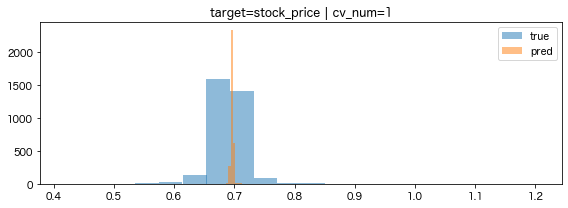

In [21]:
# plot_histgram_for_valid(
#     data_true=df_test_pred[df_test_pred["Date"] == assessment_Date]["stock_price"],
#     data_pred=df_test_pred[df_test_pred["Date"] == assessment_Date]["pred_stock_price"],
#     title=f"target=stock_price | cv_num=1",
#     figsize=(3,3)
# )

assessment_Date = "2019/11/17"
plot_histgram_for_valid(
    data_true=df_test_pred[df_test_pred["Date"] == assessment_Date]["stock_price_log1pRate"],
    data_pred=df_test_pred[df_test_pred["Date"] == assessment_Date]["pred_stock_price_log1pRate"],
    title=f"target=stock_price | cv_num=1",
    figsize=(8,3)
)

In [20]:
# df_pred_20191117 = df_test_pred[df_test_pred["Date"] == assessment_Date].copy()
# convert_columns = ["stock_price", "stock_price_1s_4r_mean"]
# df_pred_20191117[convert_columns] = df_pred_20191117[convert_columns].astype("float64")
# df_pred_20191117.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 0.9, 0.95])

# df_pred_20191117 = df_test_pred[df_test_pred["Date"] == assessment_Date].copy()
# convert_columns = ["stock_price_log1p", "stock_price_log1p_1s_4r_mean"]
# df_pred_20191117[convert_columns] = df_pred_20191117[convert_columns].astype("float64")
# df_pred_20191117.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 0.9, 0.95])

,cv_num,pred_stock_price_log1p,stock_price_log1p,stock_price_log1p_1s_4r_mean
count,3278.0,3278.000000,3278.000000,3278.000000
mean,1.0,3.091253,3.076054,3.079837
std,0.0,1.242718,1.241345,1.230834
min,1.0,0.223194,0.113342,0.147583
10%,1.0,1.306689,1.306836,1.321973
20%,1.0,1.990201,1.973633,1.984766
30%,1.0,2.503921,2.488867,2.492383
40%,1.0,2.802370,2.778906,2.785156
50%,1.0,3.127851,3.112305,3.107422
60%,1.0,3.500577,3.473047,3.470703


In [20]:
def calc_mase(true: pd.Series, pred: pd.Series, mean: pd.Series):
    mase = np.abs(true - pred) / mean
    return mase

df_pred_20191117["mase"] = calc_mase(
    true=df_pred_20191117["stock_price"],
    pred=df_pred_20191117["pred_stock_price"],
    mean=df_pred_20191117["stock_price_1s_4r_mean"]
)

df_pred_20191117 = pd.merge(df_pred_20191117, df_company_features, how="left", on="Symbol")
df_pred_20191117.sort_values("mase", ascending=False).head(20)

KeyError: 'stock_price'

大きい値の予測が大きく外れている。log変換してスケールを小さくする必要がありそう。

## 提出

In [22]:
submission_Date = "2019/11/24"

# # stock_priceのまま
# df_submission = df_test_pred[df_test_pred["Date"] == submission_Date][["Symbol", "pred_stock_price"]].copy()
# df_submission = df_submission.rename(columns={"Symbol": "id", "pred_stock_price": "y"})
# df_submission.to_csv("../output/submission_4.csv", index=False, encoding="utf-8-sig")

# # stock_price_log1p
# df_submission = df_test_pred[df_test_pred["Date"] == submission_Date][["Symbol", "pred_stock_price_log1p"]].copy()
# df_submission["undo_pred_stock_price"] = np.expm1(df_submission["pred_stock_price_log1p"])
# df_submission = df_submission.rename(columns={"Symbol": "id", "undo_pred_stock_price": "y"})
# df_submission[["id", "y"]].to_csv("../output/submission_8.csv", index=False, encoding="utf-8-sig")

# stock_price_log1p
df_submission = df_test_pred[df_test_pred["Date"] == submission_Date][["Symbol", "pred_stock_price_log1pRate", "stock_price_1s"]].copy()
df_submission["undo_pred_stock_price"] = np.expm1(df_submission["pred_stock_price_log1pRate"]) * df_submission["stock_price_1s"]
df_submission = df_submission.rename(columns={"Symbol": "id", "undo_pred_stock_price": "y"})
df_submission[["id", "y"]].to_csv("../output/submission_13.csv", index=False, encoding="utf-8-sig")

In [17]:
df_submission

,id,pred_stock_price_log1pRate,stock_price_1s,y
3278,VGSH,0.693935,60.375000,60.470114
3279,JEF,0.693935,20.640625,20.673142
3280,IVZ,0.693935,17.046875,17.073730
3281,KTCC,0.693935,5.519531,5.528227
3282,FBZ,0.693935,14.765625,14.788887
...,...,...,...,...
6551,TYG,0.693935,16.890625,16.917234
6552,VIRC,0.693935,3.679688,3.685484
6553,BIS,0.693935,14.710938,14.734113
6554,WOOD,0.693935,64.625000,64.726809
